In [11]:
import pandas as pd
from sodapy import Socrata
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import contextily as ctx
import useful_usage as u

#link : "https://raw.githubusercontent.com/greysonchung/New-York-Taxi-Data-Analysis/main/code/visualisation.ipynb"

In [12]:
yellow_results_df = u.preprocess_data("m6nq-qud6")
#green_results_df =u.preprocess_data("w7fs-fd9i")

In [13]:
# Identify pickup and dropoff borough
def drop_pick_data(frame):
    zone_df = pd.read_csv('taxi+_zone_lookup.csv')
    zone_df.info()
    data = pd.DataFrame(pd.merge(frame, zone_df[['LocationID', 'Borough']], left_on='pulocationid', right_on='LocationID')).drop('LocationID', axis=1)
    data = data.rename({'Borough':'PUborough'}, axis=1)
    data = pd.DataFrame(pd.merge(data, zone_df[['LocationID', 'Borough']], left_on='dolocationid', right_on='LocationID')).drop('LocationID', axis=1)
    data = data.rename({'Borough':'DOborough'}, axis=1)
    return data
yellow_drop_pick_data= drop_pick_data(yellow_results_df)
#green_drop_pick_data= drop_pick_data(green_results_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


In [14]:
def read_gdf():
    countries_gdf = gpd.read_file('taxi_zones/taxi_zones.shp')
    zone = pd.read_csv('taxi+_zone_lookup.csv')
    countries_gdf['geometry'] = countries_gdf['geometry'].to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
    return countries_gdf

In [15]:
def pu_zone(frame):
    pu_zone = frame.groupby(['pulocationid'], as_index=False).size()
    pu_zone = gpd.GeoDataFrame(pd.merge(pu_zone, read_gdf(), left_on='pulocationid', right_on='LocationID')).drop('LocationID', axis=1)
    pu_zone = pu_zone.to_crs(epsg=3857)
    return pu_zone
def do_data(frame):
    do_zone = frame.groupby(['dolocationid'], as_index=False).size()
    do_zone = gpd.GeoDataFrame(pd.merge(do_zone, read_gdf(), left_on='dolocationid', right_on='LocationID')).drop('LocationID', axis=1)
    do_zone = do_zone.to_crs(epsg=3857)
    return do_zone


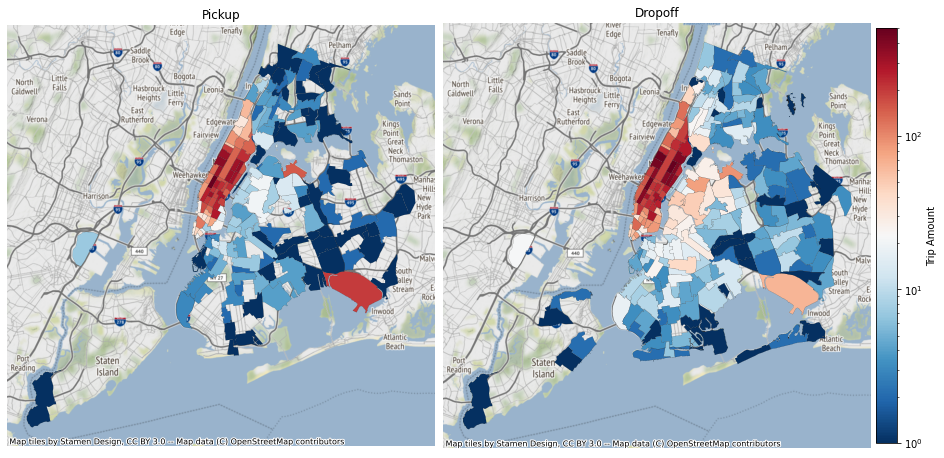

In [16]:
do_yellow_df= do_data(yellow_drop_pick_data)
pu_yellow_df= pu_zone(yellow_drop_pick_data)

# plot geospatial visualisation to compare pickup and dropoff amount from each zone
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8, wspace=0.02, hspace=0.02)
# create a normalized colorbar
vmin, vmax = pu_yellow_df['size'].min(), pu_yellow_df['size'].max()
axs[0] = pu_yellow_df.plot(column='size', linewidth=0.09, edgecolor='k', figsize=(10, 10),
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='RdBu_r', legend=False, ax=axs[0]) 
ctx.add_basemap(axs[0])
vmin, vmax = do_yellow_df['size'].min(), do_yellow_df['size'].max()
axs[1] = do_yellow_df.plot(column='size', linewidth=0.1, edgecolor='k', figsize=(10, 10),
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='RdBu_r', legend=False, ax=axs[1])
ctx.add_basemap(axs[1])
axs[0].set_title('Pickup')
axs[1].set_title('Dropoff')
axs[0].set_axis_off()
axs[1].set_axis_off()
# draw the color bar
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.72, orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Trip Amount')
plt.show()